In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

classes = train_dataset.classes
num_classes = len(classes)
print("Total Classes:", num_classes)

Using device: cuda
Total Classes: 100


In [16]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()

        # -------- Convolutional Blocks --------
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 32 → 16
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 16 → 8
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 8 → 4
        )

        # -------- Fully Connected Layers --------
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
def train_model(model, train_loader, optimizer, criterion, scheduler=None, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Step the scheduler after each epoch
        if scheduler is not None:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(train_loader):.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

In [19]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

In [20]:
def plot_and_print_confusion_matrix(model, test_loader, classes, title="Confusion Matrix"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n===== {title} =====")
    print("Rows → True Labels | Columns → Predicted Labels\n")
    print(cm)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [21]:
def show_sample_predictions(model, test_loader, classes, num_samples=8):
    model.eval()
    plt.figure(figsize=(15, 4))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(num_samples):
                plt.subplot(2, num_samples//2, i+1)
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = (img * 0.5) + 0.5  # unnormalize
                plt.imshow(img)
                plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}",
                          color=("green" if preds[i]==labels[i] else "red"))
                plt.axis('off')
            break
    plt.show()


Training ANN...
Epoch [1/20] | Loss: 3.9493
Epoch [2/20] | Loss: 3.6351
Epoch [3/20] | Loss: 3.4951
Epoch [4/20] | Loss: 3.3908
Epoch [5/20] | Loss: 3.3081
Epoch [6/20] | Loss: 3.2530
Epoch [7/20] | Loss: 3.1981
Epoch [8/20] | Loss: 3.1511
Epoch [9/20] | Loss: 3.1088
Epoch [10/20] | Loss: 3.0739
Epoch [11/20] | Loss: 3.0391
Epoch [12/20] | Loss: 3.0113
Epoch [13/20] | Loss: 2.9872
Epoch [14/20] | Loss: 2.9589
Epoch [15/20] | Loss: 2.9389
Epoch [16/20] | Loss: 2.9087
Epoch [17/20] | Loss: 2.8983
Epoch [18/20] | Loss: 2.8781
Epoch [19/20] | Loss: 2.8595
Epoch [20/20] | Loss: 2.8443
Test Accuracy: 18.52%

===== ANN Confusion Matrix (CIFAR-100) =====
Rows → True Labels | Columns → Predicted Labels

[[30  2  0 ...  0  0  0]
 [ 4 33  2 ...  1  0  0]
 [ 4  1  7 ...  0  6  1]
 ...
 [ 0  1  0 ... 12  1  1]
 [ 1  1  6 ...  0 10  1]
 [ 0  1  0 ...  0  0 11]]


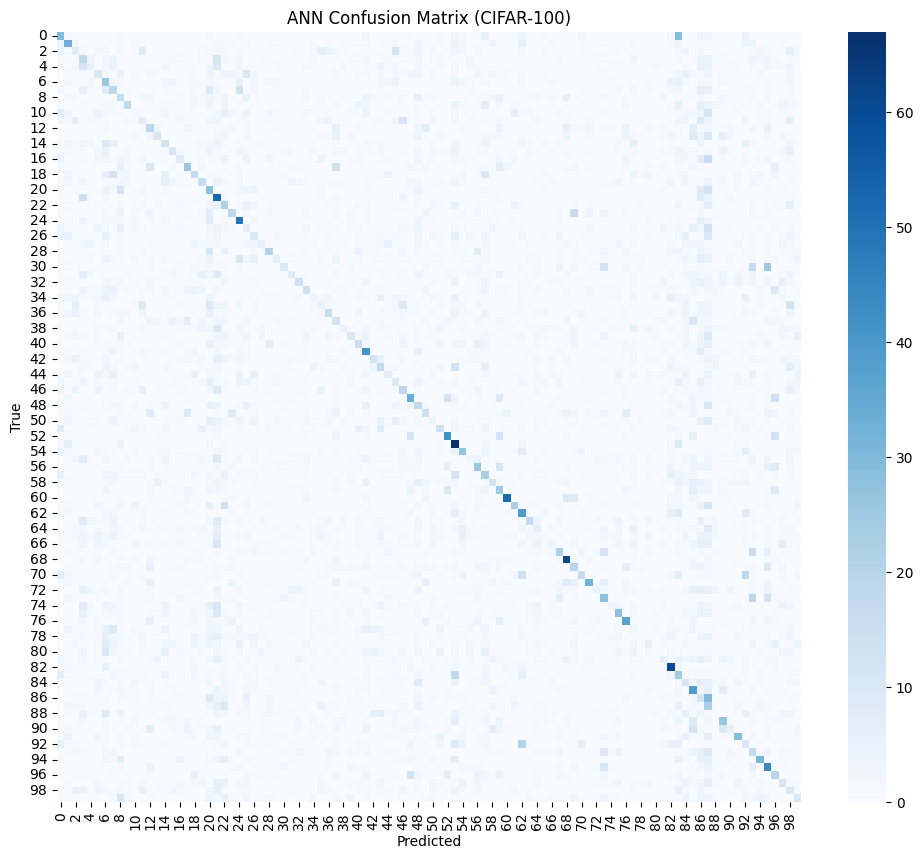

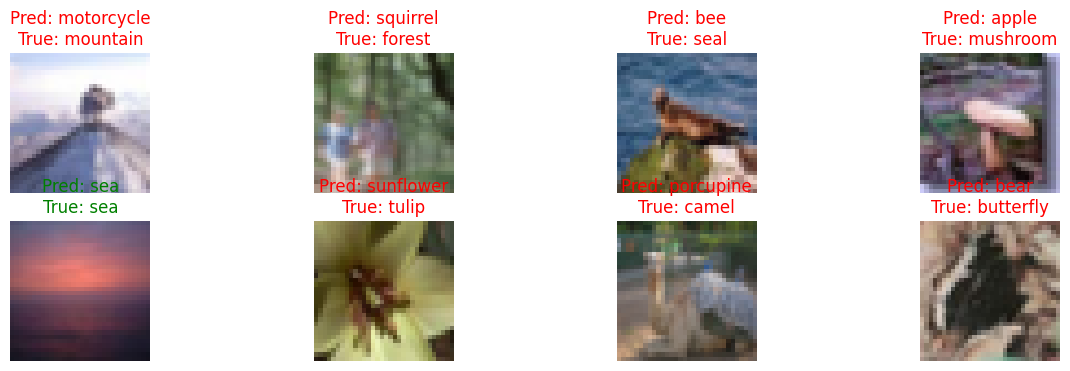

In [8]:
ann = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)

print("\nTraining ANN...")
train_model(ann, train_loader, optimizer, criterion, epochs=20)
ann_acc = test_model(ann, test_loader)
plot_and_print_confusion_matrix(ann, test_loader, classes, title="ANN Confusion Matrix (CIFAR-100)")
show_sample_predictions(ann, test_loader, classes)


Training CNN...
Epoch [1/30] | Loss: 3.6630 | LR: 0.001000
Epoch [2/30] | Loss: 2.9082 | LR: 0.001000
Epoch [3/30] | Loss: 2.5083 | LR: 0.001000
Epoch [4/30] | Loss: 2.2795 | LR: 0.001000
Epoch [5/30] | Loss: 2.1199 | LR: 0.001000
Epoch [6/30] | Loss: 1.9909 | LR: 0.001000
Epoch [7/30] | Loss: 1.8902 | LR: 0.001000
Epoch [8/30] | Loss: 1.8140 | LR: 0.001000
Epoch [9/30] | Loss: 1.7284 | LR: 0.001000
Epoch [10/30] | Loss: 1.6690 | LR: 0.001000
Epoch [11/30] | Loss: 1.6192 | LR: 0.001000
Epoch [12/30] | Loss: 1.5637 | LR: 0.001000
Epoch [13/30] | Loss: 1.5058 | LR: 0.001000
Epoch [14/30] | Loss: 1.4664 | LR: 0.001000
Epoch [15/30] | Loss: 1.4258 | LR: 0.000500
Epoch [16/30] | Loss: 1.2658 | LR: 0.000500
Epoch [17/30] | Loss: 1.1946 | LR: 0.000500
Epoch [18/30] | Loss: 1.1541 | LR: 0.000500
Epoch [19/30] | Loss: 1.1185 | LR: 0.000500
Epoch [20/30] | Loss: 1.0961 | LR: 0.000500
Epoch [21/30] | Loss: 1.0679 | LR: 0.000500
Epoch [22/30] | Loss: 1.0442 | LR: 0.000500
Epoch [23/30] | Loss: 1.

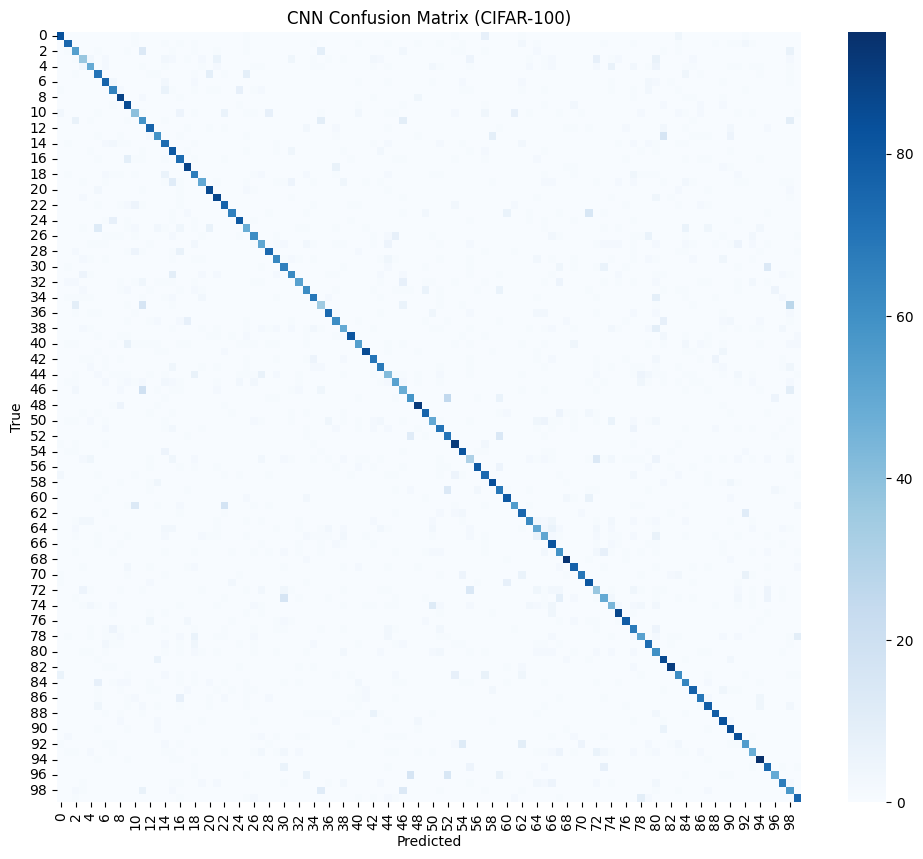

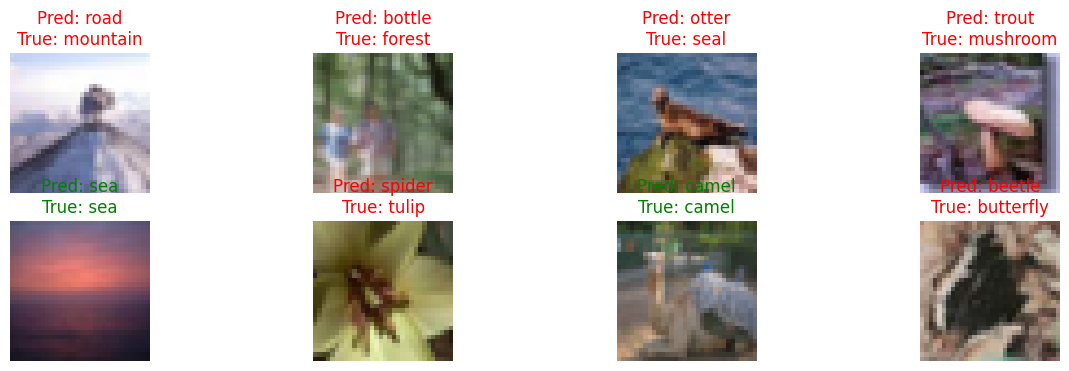

In [23]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

print("\nTraining CNN...")
train_model(cnn, train_loader, optimizer, criterion, scheduler, epochs=30)
cnn_acc = test_model(cnn, test_loader)
plot_and_print_confusion_matrix(cnn, test_loader, classes, title="CNN Confusion Matrix (CIFAR-100)")
show_sample_predictions(cnn, test_loader, classes)

In [24]:
print("\n===== Summary =====")
print(f"ANN Test Accuracy: {ann_acc:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc:.2f}%")


===== Summary =====
ANN Test Accuracy: 18.52%
CNN Test Accuracy: 67.55%
